# Aseismic slip rate inversion

In this notebook, we show some examples on how to compute the aseismic slip distribution along a creeping fault. This is a simple example using homogeneous elastic half space and no refined elastic structures. The InSAR data have already been downsampled and the GNSS data are already curated. More advanced things can be done, including stratified Green's function computation, building the input files for external solvers, etc.

This example is a simpler version of what has been done to derive the slip distribution from Jolivet et al 2023 JGR. 
 

In [5]:
#------------------------------------------------------------------
#------------------------------------------------------------------
# 
#         Inverse for creep on the North Anatolian Fault
#
#------------------------------------------------------------------
#------------------------------------------------------------------

# Faults and Pressure source
import csi.TriangularPatches as triangleflt
import csi.fault3D as rectflt
import csi.Mogi as mogi

# Data
import csi.insar as insar
import csi.gps as gps

# Tools
import csi.geodeticplot as geoplt
import csi.multifaultsolve as multiflt
import csi.transformation as transform

# Colors
import cmcrameri.cm as cm

# Imports 
import numpy as np
import os, pickle, copy, h5py
import matplotlib.pyplot as plt
import scipy.interpolate as sciint

# F*** off warnings
import warnings
warnings.simplefilter("ignore") 

# Some styling changes
from pylab import rcParams
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.labelsize'] = 'x-large'
rcParams['axes.titlesize'] = 'xx-large'
rcParams['axes.titleweight'] = 'bold'

# Reference
lon0=33.0
lat0=40.8

## Building the faults

In this section, we first build the fault objects using ready made geometries. There will be other notebooks to teach you how to do that.

In [6]:
# Create the main NAF fault and its patches
# Its patches are read from a file and the slip is initialized
naf = triangleflt('Short North Anatolian Fault Final', lon0=lon0, lat0=lat0)
naf.file2trace(os.path.join(os.getcwd(), 'DataAndModels/NAF.xy'), header=0)
naf.readPatchesFromFile(os.path.join(os.getcwd(), 'DataAndModels/Inversion/NAF.patches'), 
                        readpatchindex=False, donotreadslip=True)
naf.initializeslip(values='depth')

# For later plotting
naf.color='k'
naf.linewidth=3

# The deep portion of the fault is a rectangular fault object
deep = rectflt('Deep NAF', lon0=lon0, lat0=lat0)
deep.readPatchesFromFile(os.path.join(os.getcwd(), 'DataAndModels/Inversion/deepNAF.patches'),
                         readpatchindex=False, donotreadslip=True)
deep.computeEquivRectangle()
deep.initializeslip()
deep.setTrace(delta_depth=16., sort='x')

# The eastern portion of the fault is a rectangular fault object
east = rectflt('East NAF', lon0=lon0, lat0=lat0)
east.readPatchesFromFile(os.path.join(os.getcwd(),'DataAndModels/Inversion/eastNAF.patches'), 
                         readpatchindex=False, donotreadslip=True)
east.computeEquivRectangle()
east.initializeslip()

# The wesetrn portion of the fault is a rectangular fault object
west = rectflt('West NAF', lon0=lon0, lat0=lat0)
west.readPatchesFromFile(os.path.join(os.getcwd(),'DataAndModels/Inversion/westNAF.patches'),
                         readpatchindex=False, donotreadslip=True)
west.computeEquivRectangle()
west.initializeslip()

# All faults are stored in a single list
faults = [naf, deep, east, west]

---------------------------------
---------------------------------
Initializing fault Short North Anatolian Fault Final


FileNotFoundError: [Errno 2] No such file or directory: '/Users/romainjolivet/DataAndModels/NAF.xy'

## Mogi source

In [3]:
# We create a Mogi source to account for the small subsidence in the Ismetpasa basin
basin = mogi('Ismetpasa basin', lon0=lon0, lat0=lat0)
basin.createShape(32.64, 40.88, 3000., 6000.)

---------------------------------
---------------------------------
Initializing pressure source Ismetpasa basin


## InSAR velocity maps

In [4]:
# Here we read the downsampled InSAR data. The use of dictionnary is my own choice and you can do otherwise.
# The data have already been downsampled and the covariances have been computed ahead as well. To see how that works, check the notebook tutoInSAR.ipynb

# SAR interferometry Data
insarFiles = {'track 87': os.path.join(os.getcwd(), 'DataAndModels/Inversion/Rate_map_T87'),
              'track 65': os.path.join(os.getcwd(), 'DataAndModels/Inversion/Rate_map_T65'), 
              'track 167': os.path.join(os.getcwd(), 'DataAndModels/Inversion/Rate_map_T167')}
covFiles = {'track 87': os.path.join(os.getcwd(), 'DataAndModels/Inversion/Covariance_Sentinel-1_D87'),
            'track 65': os.path.join(os.getcwd(), 'DataAndModels/Inversion/Covariance_Sentinel-1_65'), 
            'track 167': os.path.join(os.getcwd(), 'DataAndModels/Inversion/Covariance_Sentinel-1_167')}

# Covariances
Covariances = {'track 87': {'sigma': [float(line.split()[-1]) for line in open(covFiles['track 87']+'.cov', 'r').readlines() if line.split()[1]=='Sigma'][0], 
                            'lambda': [float(line.split()[-1]) for line in open(covFiles['track 87']+'.cov', 'r').readlines() if line.split()[1]=='Lambda'][0],
                            'std': float(np.loadtxt(covFiles['track 87']+'.std'))}, 
               'track 65': {'sigma': [float(line.split()[-1]) for line in open(covFiles['track 65']+'.cov', 'r').readlines() if line.split()[1]=='Sigma'][0], 
                            'lambda': [float(line.split()[-1]) for line in open(covFiles['track 65']+'.cov', 'r').readlines() if line.split()[1]=='Lambda'][0], 
                            'std': float(np.loadtxt(covFiles['track 65']+'.std'))}, 
               'track 167': {'sigma': [float(line.split()[-1]) for line in open(covFiles['track 167']+'.cov', 'r').readlines() if line.split()[1]=='Sigma'][0], 
                             'lambda': [float(line.split()[-1]) for line in open(covFiles['track 167']+'.cov', 'r').readlines() if line.split()[1]=='Lambda'][0],
                             'std': float(np.loadtxt(covFiles['track 167']+'.std'))}}

# I create a holder to store the InSAR data
InSARs = []

# I iterate over the available data
for data in insarFiles:
    
    # Get the file names
    dataPath = insarFiles[data]
    
    # Create an InSAR object
    sar = insar(data, lat0=lat0lon0=lon0, )
    
    # Read the downsampled data (varres is the old name of the downsampler originally written in Matlab by Mark Simons @CalTech
    sar.read_from_varres(dataPath, factor=1.0, step=0.0, header=2, cov=False) # Already in mm so factor = 1
    
    # Build the data covariance matrix from the info we collected above
    sar.buildCd(Covariances[data]['sigma'], Covariances[data]['lambda'])
    
    # Add the actual variance on the diagonal
    np.fill_diagonal(sar.Cd, Covariances[data]['std']**2)
    
    # Store this InSAR object
    InSARs.append(sar)

---------------------------------
---------------------------------
Initialize InSAR data set track 87
Read from file /Users/romainjolivet/MYBIN/csi/notebooks/DataAndModels/Inversion/Rate_map_T87 into data set track 87
---------------------------------
---------------------------------
Initialize InSAR data set track 65
Read from file /Users/romainjolivet/MYBIN/csi/notebooks/DataAndModels/Inversion/Rate_map_T65 into data set track 65
---------------------------------
---------------------------------
Initialize InSAR data set track 167
Read from file /Users/romainjolivet/MYBIN/csi/notebooks/DataAndModels/Inversion/Rate_map_T167 into data set track 167


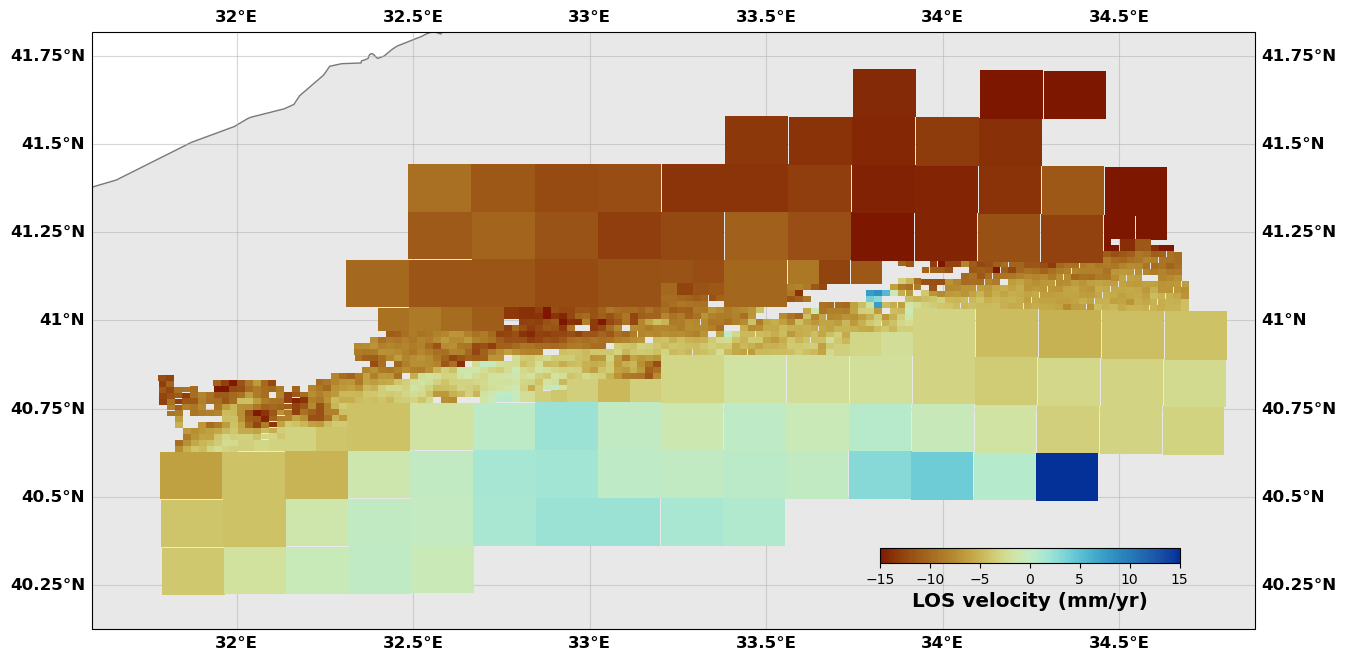

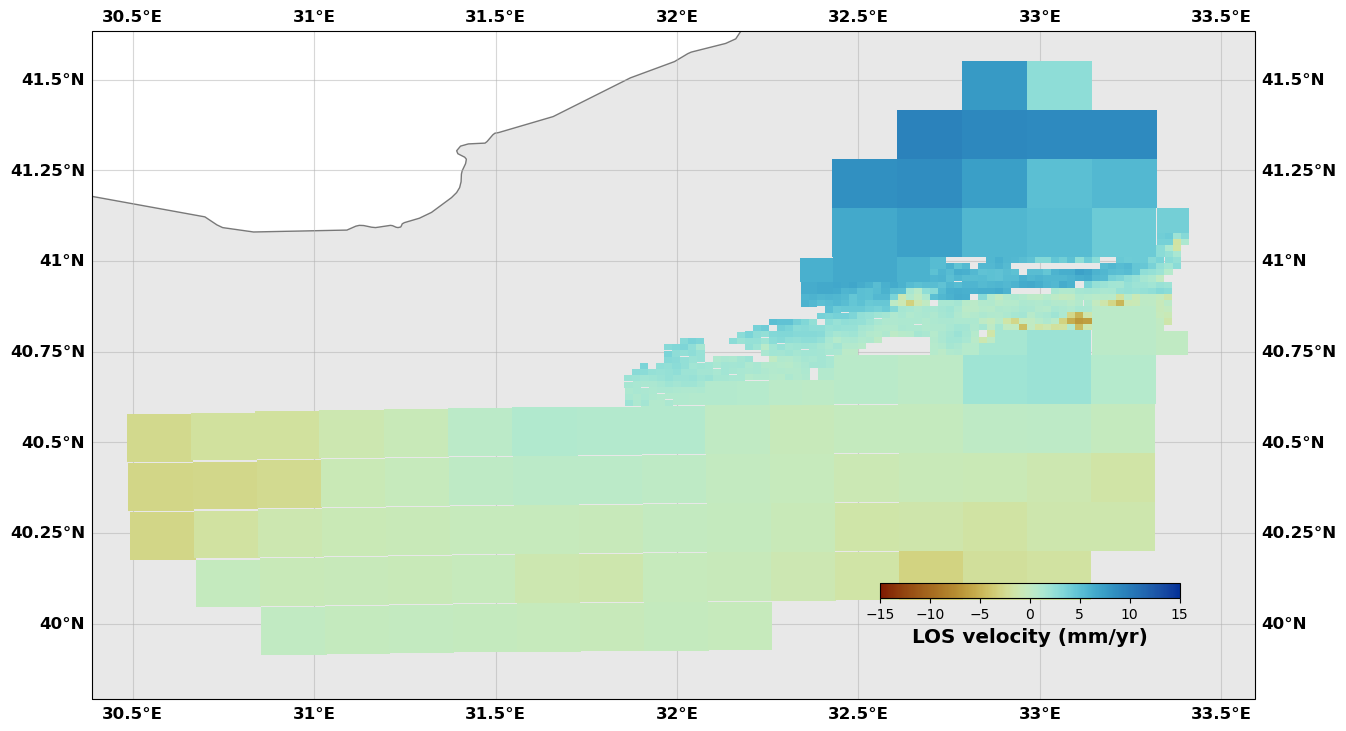

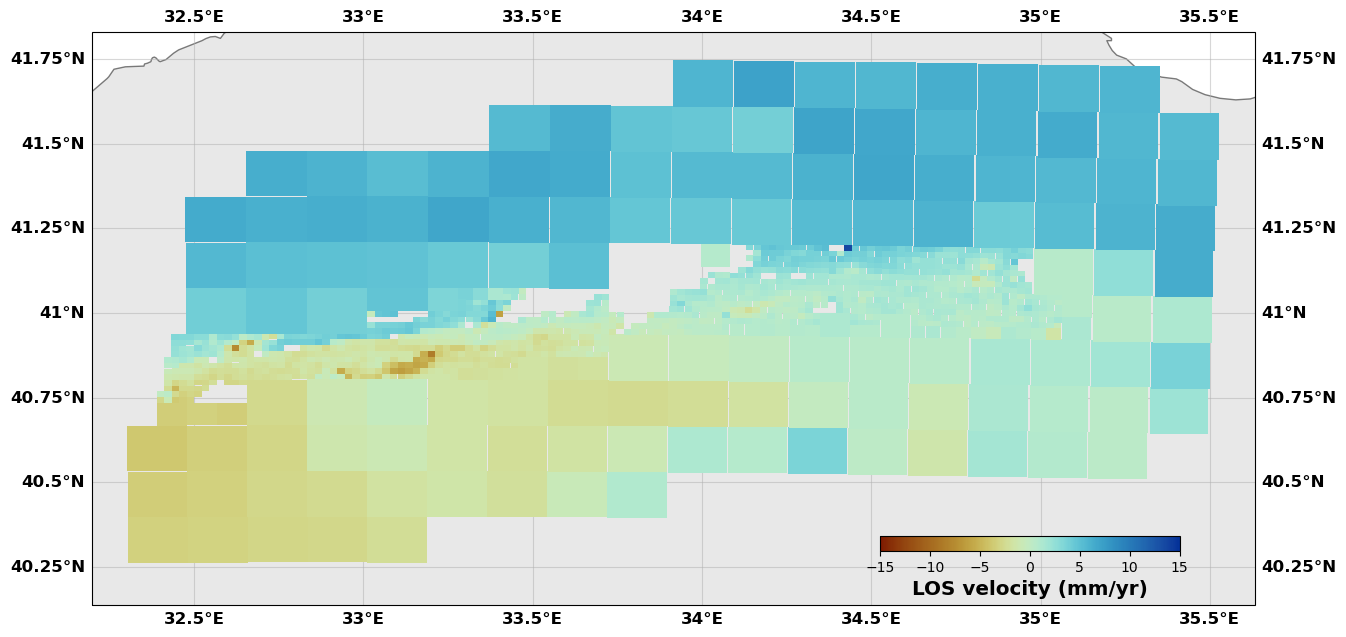

In [5]:
# Show me
for sar in InSARs:
    sar.plot(plotType='decimate', norm=[-15, 15], figsize=(15,15), edgewidth=0.0, 
             cmap=cm.roma, cbaxis=[0.65, 0.34, 0.2, 0.01], cblabel='LOS velocity (mm/yr)')

## GPS velocities

In [6]:
# We read the GNSS velocities from a curated file

# Create an object
ismenet = gps('Ismenet Velocity', lon0=lon0, lat0=lat0)

# Use the read_from_enu method (there is other methods for other formats and if your favorite format is missing, please add it)
ismenet.read_from_enu(os.path.join(os.getcwd(), 'DataAndModels/Inversion/GNSS.enu'), header=0)

# I don't want to use the vertical component
ismenet.vel_enu[:,2] = np.nan

# Build the data covariance matrix
ismenet.buildCd()

---------------------------------
---------------------------------
Initialize GPS array Ismenet Velocity
Read data from file /Users/romainjolivet/MYBIN/csi/notebooks/DataAndModels/Inversion/GNSS.enu into data set Ismenet Velocity


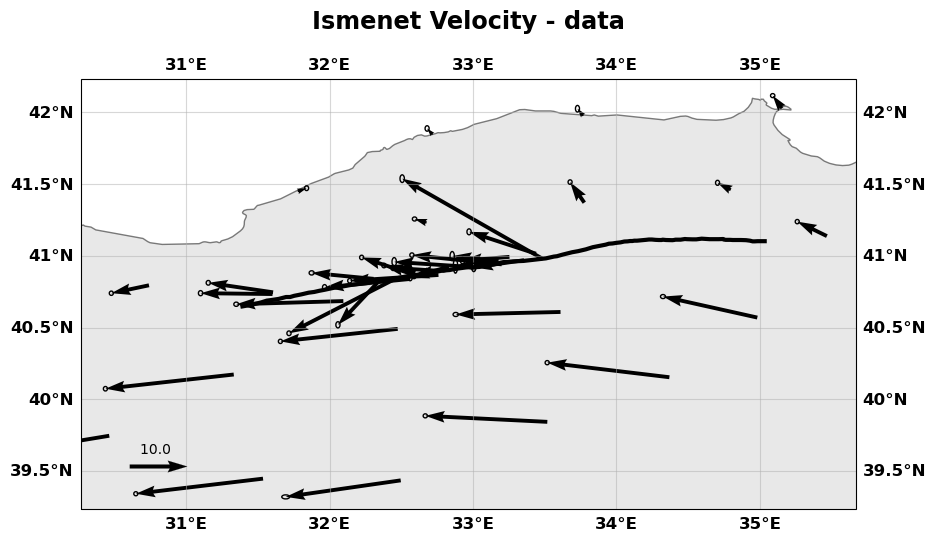

In [7]:
# Show me
ismenet.plot(figsize=(10,10), scale=25., faults=[naf])

## Building the Green's functions

In this example, we have four faults. One of them, the naf object, has triangular patches. We use the Meade solution for triangular dislocation in an elastic halfspace. The three other ones are made of rectangular patches and we use the classic Okada formulation that is implemented in Okada4py (to be installed separately from csi. Go check https://github.com/jolivetr/okada4py).

In [8]:
# Build the GFs for each dataset and each fault independently
# I set vertical to False since I don't want to use the vertical component of the GNSS data

# InSAR data
for sar in InSARs: 
    for fault in faults: 
        fault.buildGFs(sar, vertical=True)
        # By default, left-lateral is positive for the triangular patch and I want to use NNLS at some point, so I need to change the sign
        fault.G[sar.name]['strikeslip'] *= -1.
        
# GNSS data
for gnss in [ismenet]: 
    for fault in faults: 
        fault.buildGFs(gnss, vertical=False)
        # By default, left-lateral is positive and I want to use NNLS at some point, so I need to change the sign
        fault.G[gnss.name]['strikeslip'] *= -1.

# Pressure drop is negative in the model but we want to have it positive to be able to use NNLS
for sar in InSARs: basin.buildGFs(sar, vertical=True)
for gnss in [ismenet]: basin.buildGFs(gnss, vertical=False)
for data in InSARs+[ismenet]: basin.G[data.name]['pressure'] *= -1e6 # Pressure will be in MPa

Greens functions computation method: Meade
---------------------------------
---------------------------------
Building Green's functions for the data set 
track 87 of type insar in a homogeneous half-space
 Patch: 1292 / 1292  
Greens functions computation method: Okada
---------------------------------
---------------------------------
Building Green's functions for the data set 
track 87 of type insar in a homogeneous half-space
 Patch: 5 / 5  
Greens functions computation method: Okada
---------------------------------
---------------------------------
Building Green's functions for the data set 
track 87 of type insar in a homogeneous half-space
 Patch: 1 / 1  
Greens functions computation method: Okada
---------------------------------
---------------------------------
Building Green's functions for the data set 
track 87 of type insar in a homogeneous half-space
 Patch: 1 / 1  
Greens functions computation method: Meade
---------------------------------
-------------------------

## Creating a transformation object

In an inversion, the fault object does not really care about reference frames. Furthermore, InSAR is a relative measurement. Therefore, you need to have some degree of freedom between the different datasets so they fall in the same reference frame. If you have carefully done that ahead, don't use a transformation object. However, as soon as you use InSAR, you should...

In [9]:
# Let's make a single data list
Datas = InSARs + [ismenet]

In [10]:
# Create a transformation object
trans = transform('Reference frame Corrections', lon0=lon0, lat0=lat0)

# Build the GFs for the transformations. Here, we will solve for a bilinear plane in each InSAR velocity map and estimate a translation in the GNSS data
# Other options are possible, such as a 'full' Helmert transform, or a simple 'translation' or 'rotation' in the GNSS data. For InSAR, there is only 2 options (1 and 3)   
trans.buildGFs(Datas, [1,1,1,'translation'])

---------------------------------
---------------------------------
Initializing transformation Reference frame Corrections


## Assembling the data

Different elements must be assembled together to enter in the inversion. Assembling means concatenating the various data vectors and GFs and covariance matrices before actually inverting the problem.

In [11]:
# Assemble the GFs and the data covariance matrices for the fault objects
# Here, I only use the strike slip component and discard the dipslip
for fault in faults:
    fault.assembleGFs(Datas, slipdir='s')
    fault.assembled(Datas)
    fault.assembleCd(Datas)

# Same for the pressure source
basin.assembleGFs(Datas)
basin.assembled(Datas)
basin.assembleCd(Datas)
    
# Same for the transformation 
trans.assembleGFs(Datas)
trans.assembled(Datas)
trans.assembleCd(Datas)

---------------------------------
---------------------------------
Assembling G for fault Short North Anatolian Fault Final
Dealing with track 87 of type insar
Dealing with track 65 of type insar
Dealing with track 167 of type insar
Dealing with Ismenet Velocity of type gps
---------------------------------
---------------------------------
Assembling d vector
Dealing with data track 87
Dealing with data track 65
Dealing with data track 167
Dealing with data Ismenet Velocity
---------------------------------
---------------------------------
Assembling G for fault Deep NAF
Dealing with track 87 of type insar
Dealing with track 65 of type insar
Dealing with track 167 of type insar
Dealing with Ismenet Velocity of type gps
---------------------------------
---------------------------------
Assembling d vector
Dealing with data track 87
Dealing with data track 65
Dealing with data track 167
Dealing with data Ismenet Velocity
---------------------------------
-----------------------------

## Solver

This is where the action is. We will make different attempts at getting an acceptable solution. 

### Regularization
In CSI, there is no fancy regularization scheme. Basically, we can use 
- buildCm which builds a Cm matrix based on the approach of Radiguet et al 2010 (exponential decay of the model covariance as a function of the distance between pacthes)
- buildCmXY which is the same but with different distances along horizontal and vertical directions
- buildCmGaussian which builds a diagonal Cm matrix. 

Currently, there is no Laplacian smoothing or norm damping although one can show equivalence between the regularizations we have implemented and these formers. I do not use any regularization when using AlTar, the Bayesian sampler, so this is really not my priority. Now, if you feel like implementing new ones, be my guest!

In [12]:
# Model covariance matrix for the naf. We use different characteristic distances along the horizontal and vertical directions
naf.buildCmXY(20., (10., 1.))

# For the deep, west and east faults, we use a diagonal model covariance matrix
west.buildCmGaussian([.01])
east.buildCmGaussian([.01])
deep.buildCmGaussian([100.]) 

# Same for trans and the Mogi pressure source
trans.buildCm(1.)
basin.buildCm(1.)

---------------------------------
---------------------------------
Assembling the Cm matrix 
Sigma = 20.0
Lambda = (10.0, 1.0)
Lambda0 = 0.2722630725042683
---------------------------------
---------------------------------
Assembling the Cm matrix 


### First attempt

Generalized least squares withtout any other constraints than those implemented in the data and model covariances. The solution is the maximum of the posterior PDF which is a Gaussian distribution assuming Gaussian priors and likelihood.

In [13]:
# Prepare solver
slv = multiflt('NAF slip rate', faults+[basin, trans])
slv.assembleGFs()
slv.assembleCm()

# Solve 
slv.GeneralizedLeastSquareSoln()

# Distribute results
slv.distributem()
print('Basin pressure drop: {} MPa'.format(basin.deltapressure))

---------------------------------
---------------------------------
Initializing solver object
Not a fault detected
Number of data: 3554
Number of parameters: 1305
Parameter Description ----------------------------------
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
Short North Anatolian Fault Final||   0 - 1292 ||None        ||None        ||None        ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
Deep NAF                      ||1292 - 1297 ||None        ||None        ||None        ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
East NAF                      ||1297 - 1298 ||None        ||None        ||None        ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parm

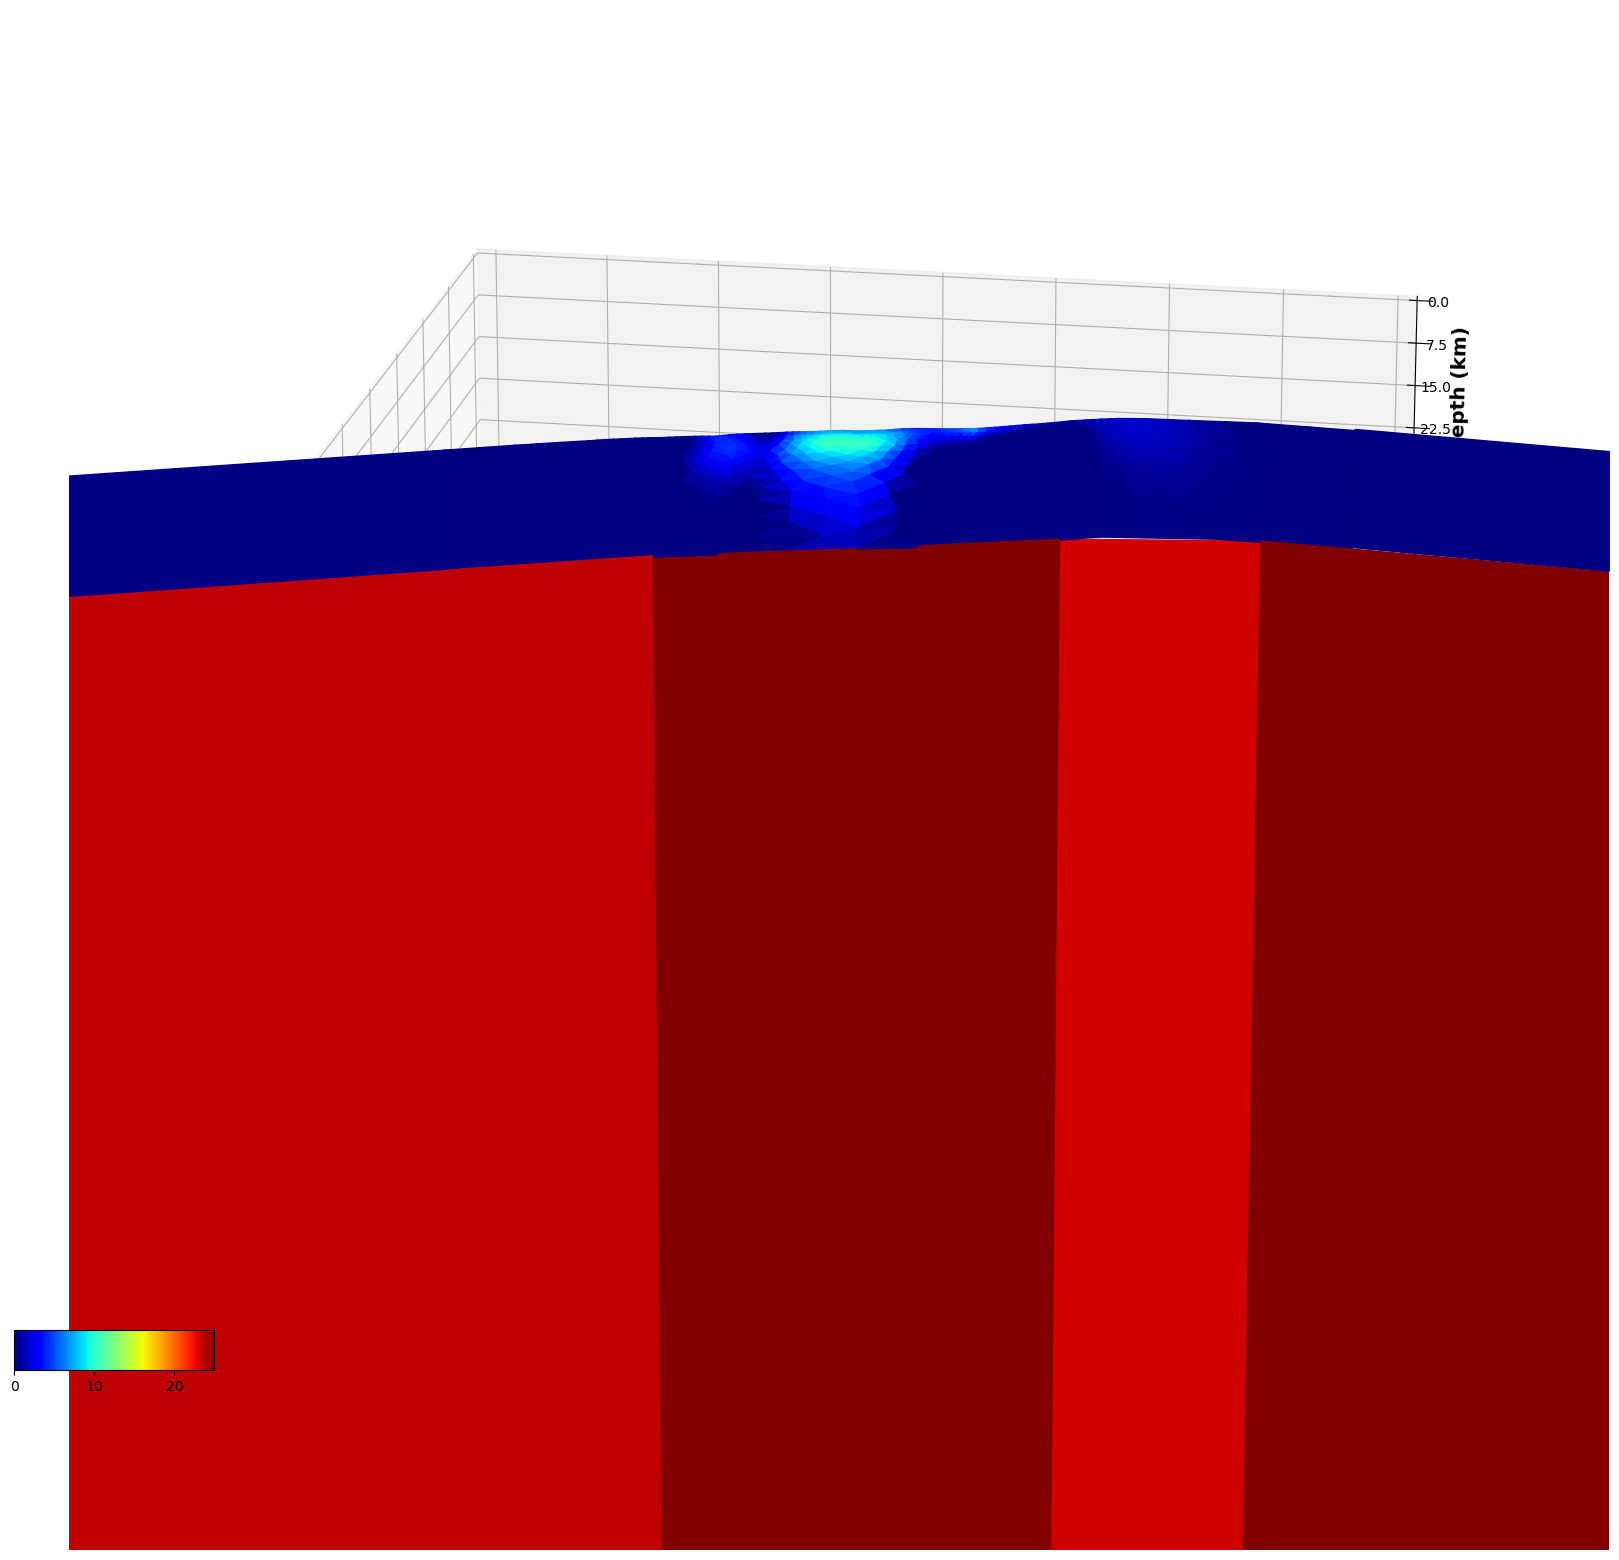

In [14]:
# Make a plot

# Plot the whole thing                  
gp = geoplt(31., 40., 35., 42., figsize=((20,20), (15, 7)))
      
# Plot the faults
gp.faultpatches(naf, slip='strikeslip', colorbar=True, plot_on_2d=False, norm=[0, 25], cmap='jet')
gp.faultpatches(deep, slip='strikeslip', colorbar=False, plot_on_2d=False, norm=[0, 25], cmap='jet')
gp.faultpatches(east, slip='strikeslip', colorbar=False, plot_on_2d=False, norm=[0, 25], cmap='jet')
gp.faultpatches(west, slip='strikeslip', colorbar=False, plot_on_2d=False, norm=[0, 25], cmap='jet')

# Set views
gp.setzaxis(30.)
gp.set_view(20., 280., shape=(1., 1., 0.3))
gp.show(showFig=['fault'])

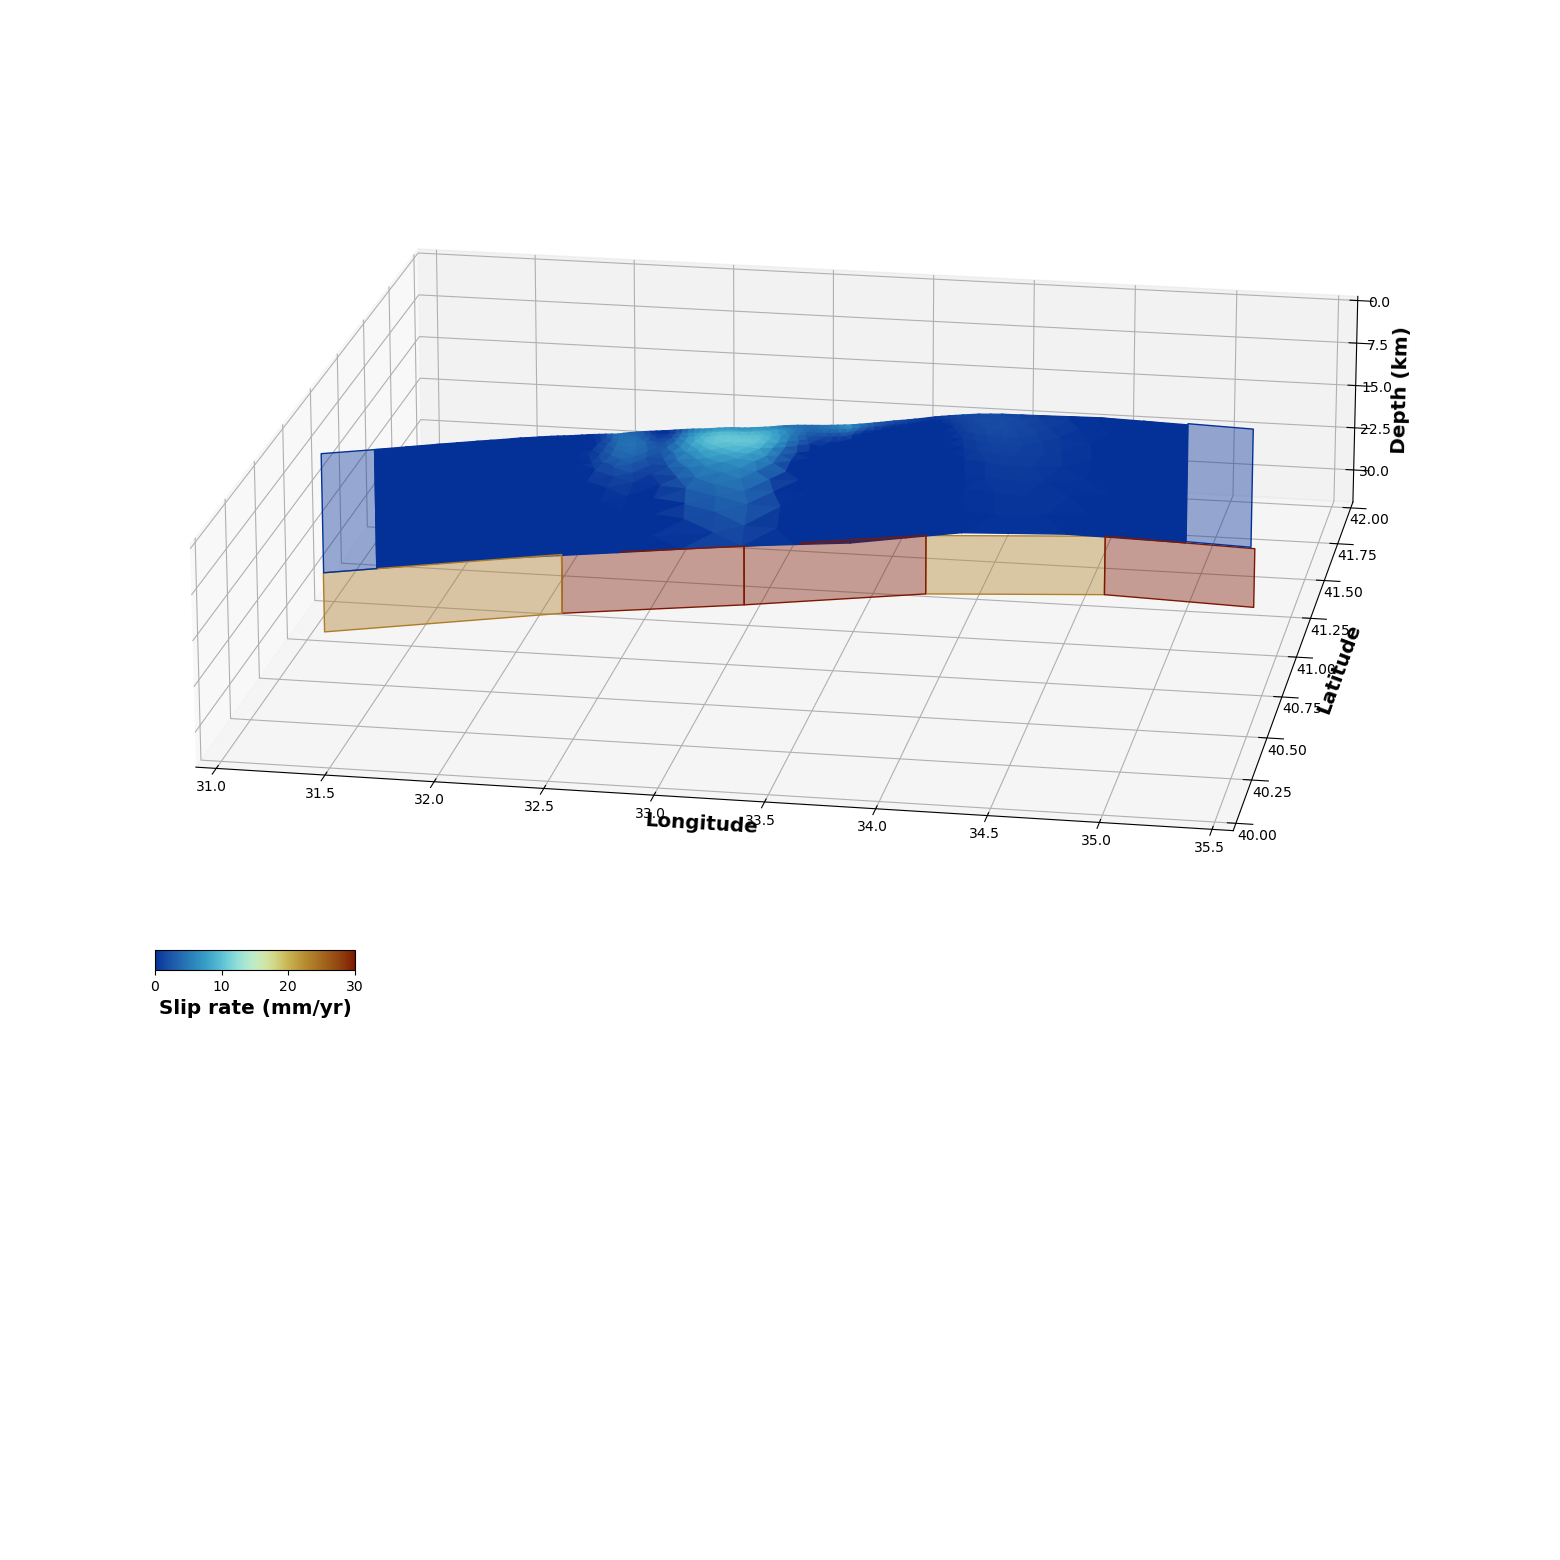

In [15]:
# This plot is not very nice. Therefore, we will modify the patches we have in the deep and east and west objects to make them nicer.
# CSI includes methods to change the shape of patches but it is simpler to read again new geometries (and we do not calculate the GFs again) so the prediction is based on the large faults but the plot is nicer.
# We will also change the colormap to a more appropriate one and customize everything. 

deep.readPatchesFromFile(os.path.join(os.getcwd(), 'DataAndModels/Inversion/deepNAF.plotpatches'),
                         donotreadslip=True, readpatchindex=False)
east.readPatchesFromFile(os.path.join(os.getcwd(), 'DataAndModels/Inversion/eastNAF.plotpatches'),
                         donotreadslip=True, readpatchindex=False)
west.readPatchesFromFile(os.path.join(os.getcwd(), 'DataAndModels/Inversion/westNAF.plotpatches'),
                         donotreadslip=True, readpatchindex=False)
slv.distributem()

# Plot the whole thing                  
gp = geoplt(31., 40., 35.5, 42., figsize=((20,20), (15, 7)))
      
# Plot the faults
gp.faultpatches(naf, slip='strikeslip', colorbar=True, plot_on_2d=False, norm=[0, 30], cmap=cm.roma_r, 
                cbaxis=[0.2, 0.4, 0.1, 0.01], cblabel='Slip rate (mm/yr)')
gp.faultpatches(deep, slip='strikeslip', colorbar=False, alpha=0.4, plot_on_2d=False, norm=[0, 30], cmap=cm.roma_r)
gp.faultpatches(east, slip='strikeslip', colorbar=False, alpha=0.4, plot_on_2d=False, norm=[0, 30], cmap=cm.roma_r)
gp.faultpatches(west, slip='strikeslip', colorbar=False, alpha=0.4, plot_on_2d=False, norm=[0, 30], cmap=cm.roma_r)

# Set views
gp.setzaxis(30.)
gp.set_view(20., 280., shape=(1., 1., 0.3))
gp.show(showFig=['fault'])

### Second attempt

We now use the NNLS implementation (i.e. non-negative least squares).

In [16]:
# For safety reasons, we re-assemble everyhting
for fault in faults:
    fault.assembleGFs(Datas, slipdir='s')
    fault.assembled(Datas)
    fault.assembleCd(Datas)

# Same for the pressure source
basin.assembleGFs(Datas)
basin.assembled(Datas)
basin.assembleCd(Datas)
    
# Same for the transformation 
trans.assembleGFs(Datas)
trans.assembled(Datas)
trans.assembleCd(Datas)

---------------------------------
---------------------------------
Assembling G for fault Short North Anatolian Fault Final
Dealing with track 87 of type insar
Dealing with track 65 of type insar
Dealing with track 167 of type insar
Dealing with Ismenet Velocity of type gps
---------------------------------
---------------------------------
Assembling d vector
Dealing with data track 87
Dealing with data track 65
Dealing with data track 167
Dealing with data Ismenet Velocity
---------------------------------
---------------------------------
Assembling G for fault Deep NAF
Dealing with track 87 of type insar
Dealing with track 65 of type insar
Dealing with track 167 of type insar
Dealing with Ismenet Velocity of type gps
---------------------------------
---------------------------------
Assembling d vector
Dealing with data track 87
Dealing with data track 65
Dealing with data track 167
Dealing with data Ismenet Velocity
---------------------------------
-----------------------------

In [17]:
# And we rebuild the model covariances
# Model covariance matrix for the naf. We use different characteristic distances along the horizontal and vertical directions
naf.buildCmXY(20., (10., 1.))

# For the deep, west and east faults, we use a diagonal model covariance matrix
west.buildCmGaussian([.01])
east.buildCmGaussian([.01])
deep.buildCmGaussian([100.]) 

# Same for trans and the Mogi pressure source
trans.buildCm(1.)
basin.buildCm(1.)

---------------------------------
---------------------------------
Assembling the Cm matrix 
Sigma = 20.0
Lambda = (10.0, 1.0)
Lambda0 = 0.2722630725042683
---------------------------------
---------------------------------
Assembling the Cm matrix 


In [18]:
# Prepare solver
slv = multiflt('NAF slip rate', faults+[basin, trans])
slv.assembleGFs()
slv.assembleCm()

# prior model 
mprior = np.zeros((slv.Np,))

# Solve 
n = [i for i,t in enumerate(slv.paramTypes) if t[0]=='Reference frame Corrections']
mprior[n] = -100.
slv.ConstrainedLeastSquareSoln(method='nnls', mprior=mprior)

# Distribute results
slv.distributem()
print('Basin pressure drop: {} MPa'.format(basin.deltapressure))

---------------------------------
---------------------------------
Initializing solver object
Not a fault detected
Number of data: 3554
Number of parameters: 1305
Parameter Description ----------------------------------
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
Short North Anatolian Fault Final||   0 - 1292 ||None        ||None        ||None        ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
Deep NAF                      ||1292 - 1297 ||None        ||None        ||None        ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
East NAF                      ||1297 - 1298 ||None        ||None        ||None        ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parm

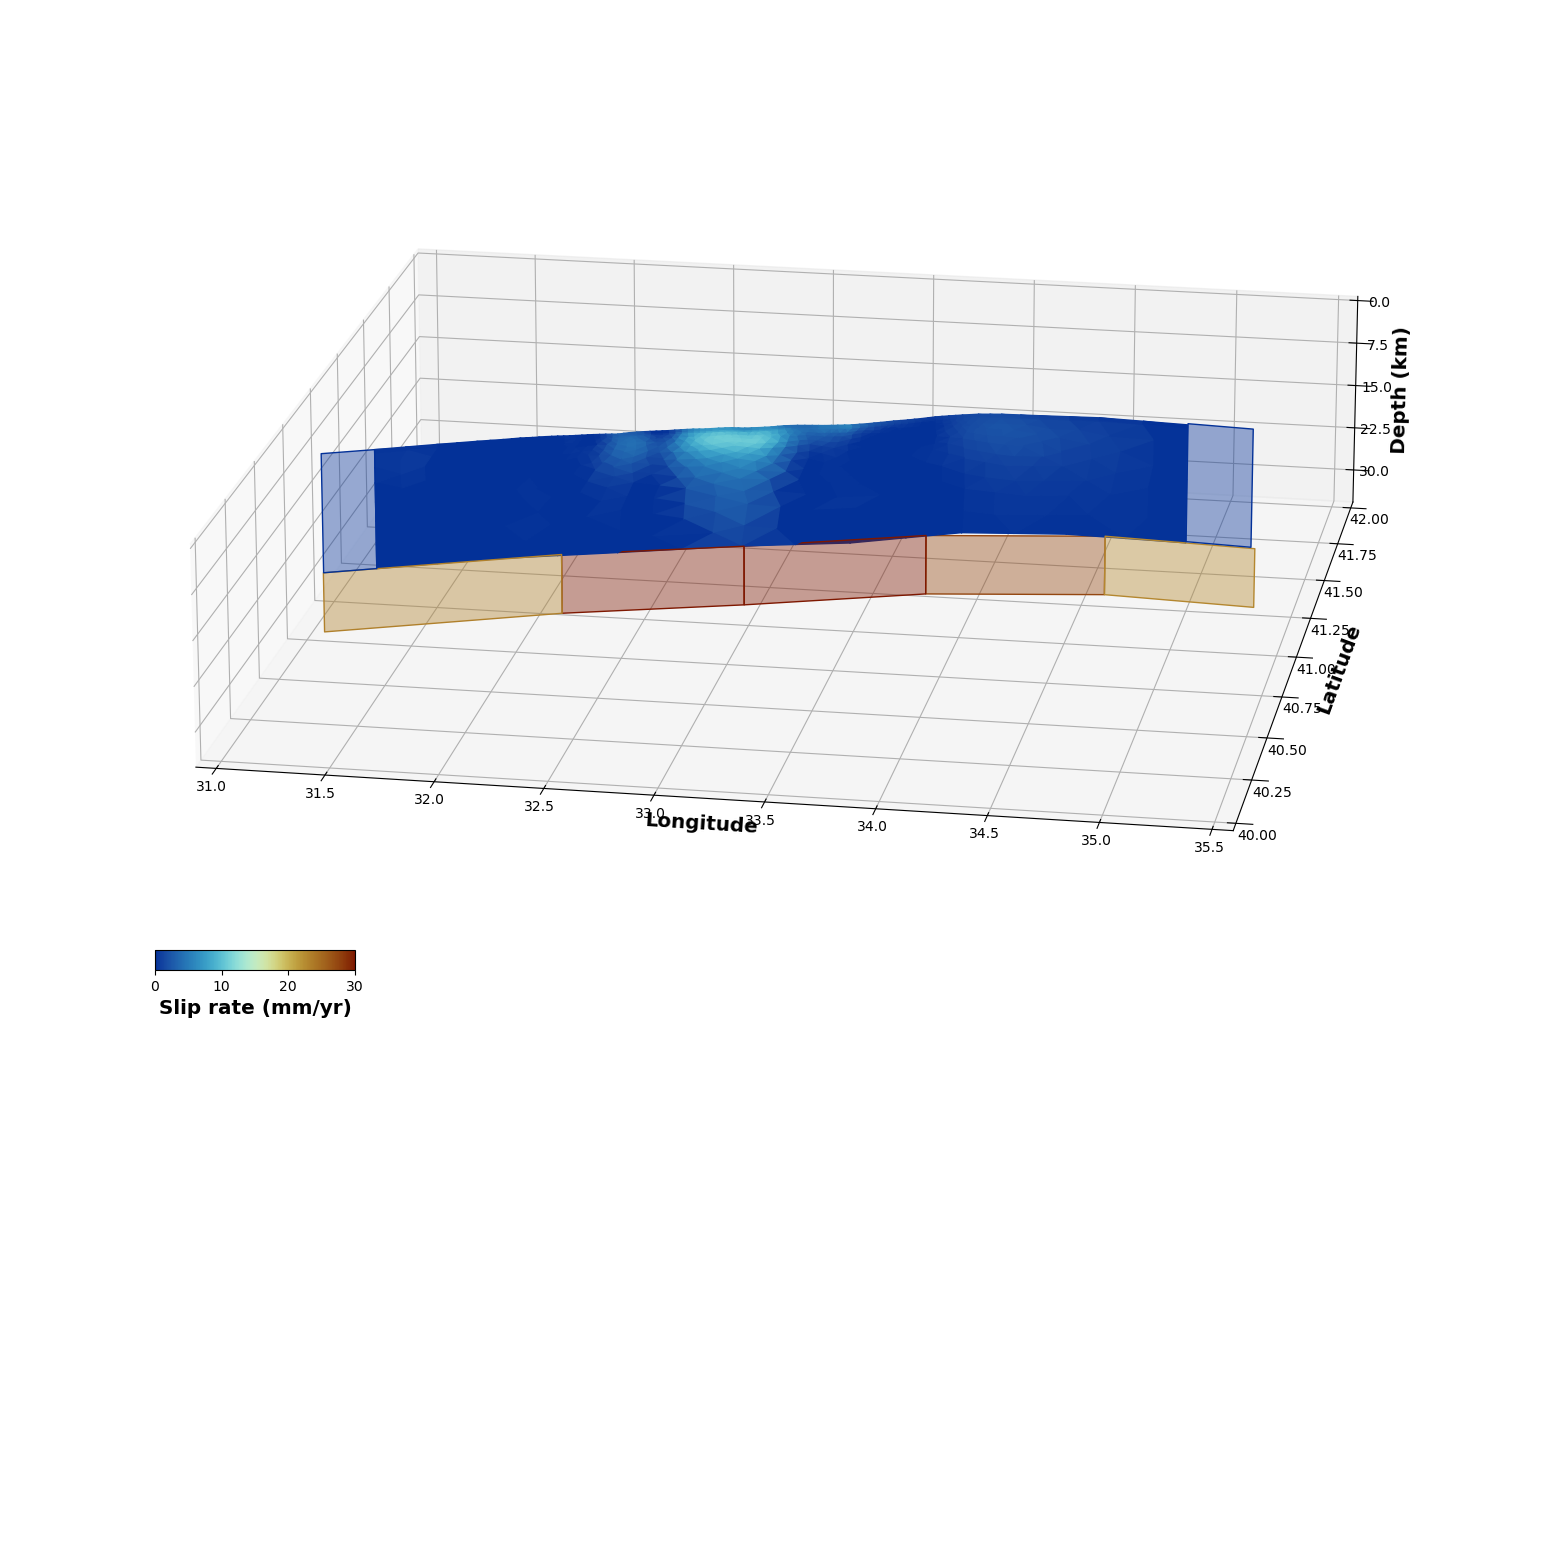

In [19]:
# Show me

# Create a figure                  
gp = geoplt(31., 40., 35.5, 42., figsize=((20,20), (15, 7)))
      
# Plot the faults
gp.faultpatches(naf, slip='strikeslip', colorbar=True, plot_on_2d=False, norm=[0, 30], cmap=cm.roma_r, 
                cbaxis=[0.2, 0.4, 0.1, 0.01], cblabel='Slip rate (mm/yr)')
gp.faultpatches(deep, slip='strikeslip', colorbar=False, alpha=0.4, plot_on_2d=False, norm=[0, 30], cmap=cm.roma_r)
gp.faultpatches(east, slip='strikeslip', colorbar=False, alpha=0.4, plot_on_2d=False, norm=[0, 30], cmap=cm.roma_r)
gp.faultpatches(west, slip='strikeslip', colorbar=False, alpha=0.4, plot_on_2d=False, norm=[0, 30], cmap=cm.roma_r)

# Set views
gp.setzaxis(30.)
gp.set_view(20., 280., shape=(1., 1., 0.3))
gp.show(showFig=['fault'])

### Third attempt

Now we will be smarter. We want all patches at the bottom of the fault to slip at the same rate.

In [20]:
# For safety reasons, we re-assemble everyhting
for fault in faults:
    fault.assembleGFs(Datas, slipdir='s')
    fault.assembled(Datas)
    fault.assembleCd(Datas)

# Same for the pressure source
basin.assembleGFs(Datas)
basin.assembled(Datas)
basin.assembleCd(Datas)
    
# Same for the transformation 
trans.assembleGFs(Datas)
trans.assembled(Datas)
trans.assembleCd(Datas)

# And we rebuild the model covariances
# Model covariance matrix for the naf. We use different characteristic distances along the horizontal and vertical directions
naf.buildCmXY(20., (10., 1.))

# For the deep, west and east faults, we use a diagonal model covariance matrix
west.buildCmGaussian([.01])
east.buildCmGaussian([.01])
deep.buildCmGaussian([100.]) 

# Same for trans and the Mogi pressure source
trans.buildCm(1.)
basin.buildCm(1.)

---------------------------------
---------------------------------
Assembling G for fault Short North Anatolian Fault Final
Dealing with track 87 of type insar
Dealing with track 65 of type insar
Dealing with track 167 of type insar
Dealing with Ismenet Velocity of type gps
---------------------------------
---------------------------------
Assembling d vector
Dealing with data track 87
Dealing with data track 65
Dealing with data track 167
Dealing with data Ismenet Velocity
---------------------------------
---------------------------------
Assembling G for fault Deep NAF
Dealing with track 87 of type insar
Dealing with track 65 of type insar
Dealing with track 167 of type insar
Dealing with Ismenet Velocity of type gps
---------------------------------
---------------------------------
Assembling d vector
Dealing with data track 87
Dealing with data track 65
Dealing with data track 167
Dealing with data Ismenet Velocity
---------------------------------
-----------------------------

In [21]:
# Prepare solver
slv = multiflt('NAF slip rate', faults+[basin, trans])
slv.assembleGFs()
slv.assembleCm()

# Strong constraint to have linked parameters. Here, we build a list of the indexes of the parameters that we want to force being equal
ss = [int(s) for s in slv.paramDescription[deep.name]['Strike Slip'].split() if s!='-']

# Equalize Parameters: Here, the equalizeParams methode simply sums the GFs of the parameters indicated by their indexes in ss to make it a single parameter
slv.equalizeParams([i for i in range(ss[0], ss[1])], Cm=[100. for i in range(ss[0], ss[1])])

# This describes the new structure of the model space
slv.describeParams(redo=False)

# mprior
mprior = np.zeros((slv.Np,))

# Solve nnls: Since we use nnls, we provide a negative prior for the paraeteres that are not necessarily only positive
n = [i for i,t in enumerate(slv.paramTypes) if t[0]=='Reference frame Corrections']
mprior[n] = -100.
slv.ConstrainedLeastSquareSoln(mprior=mprior, method='nnls')

# Restore: we restore the original structure of the model space
slv.unequalizeParams()

# Distribute results
slv.distributem()

# Show me some stuff
print('Basin pressure drop: {} MPa'.format(basin.deltapressure))
print('Deep slip rate: {} mm/yr'.format(deep.slip[0][0]))


---------------------------------
---------------------------------
Initializing solver object
Not a fault detected
Number of data: 3554
Number of parameters: 1305
Parameter Description ----------------------------------
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
Short North Anatolian Fault Final||   0 - 1292 ||None        ||None        ||None        ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
Deep NAF                      ||1292 - 1297 ||None        ||None        ||None        ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parms 
East NAF                      ||1297 - 1298 ||None        ||None        ||None        ||None        
-----------------
Fault Name                    ||Strike Slip ||Dip Slip    ||Tensile     ||Coupling    ||Extra Parm

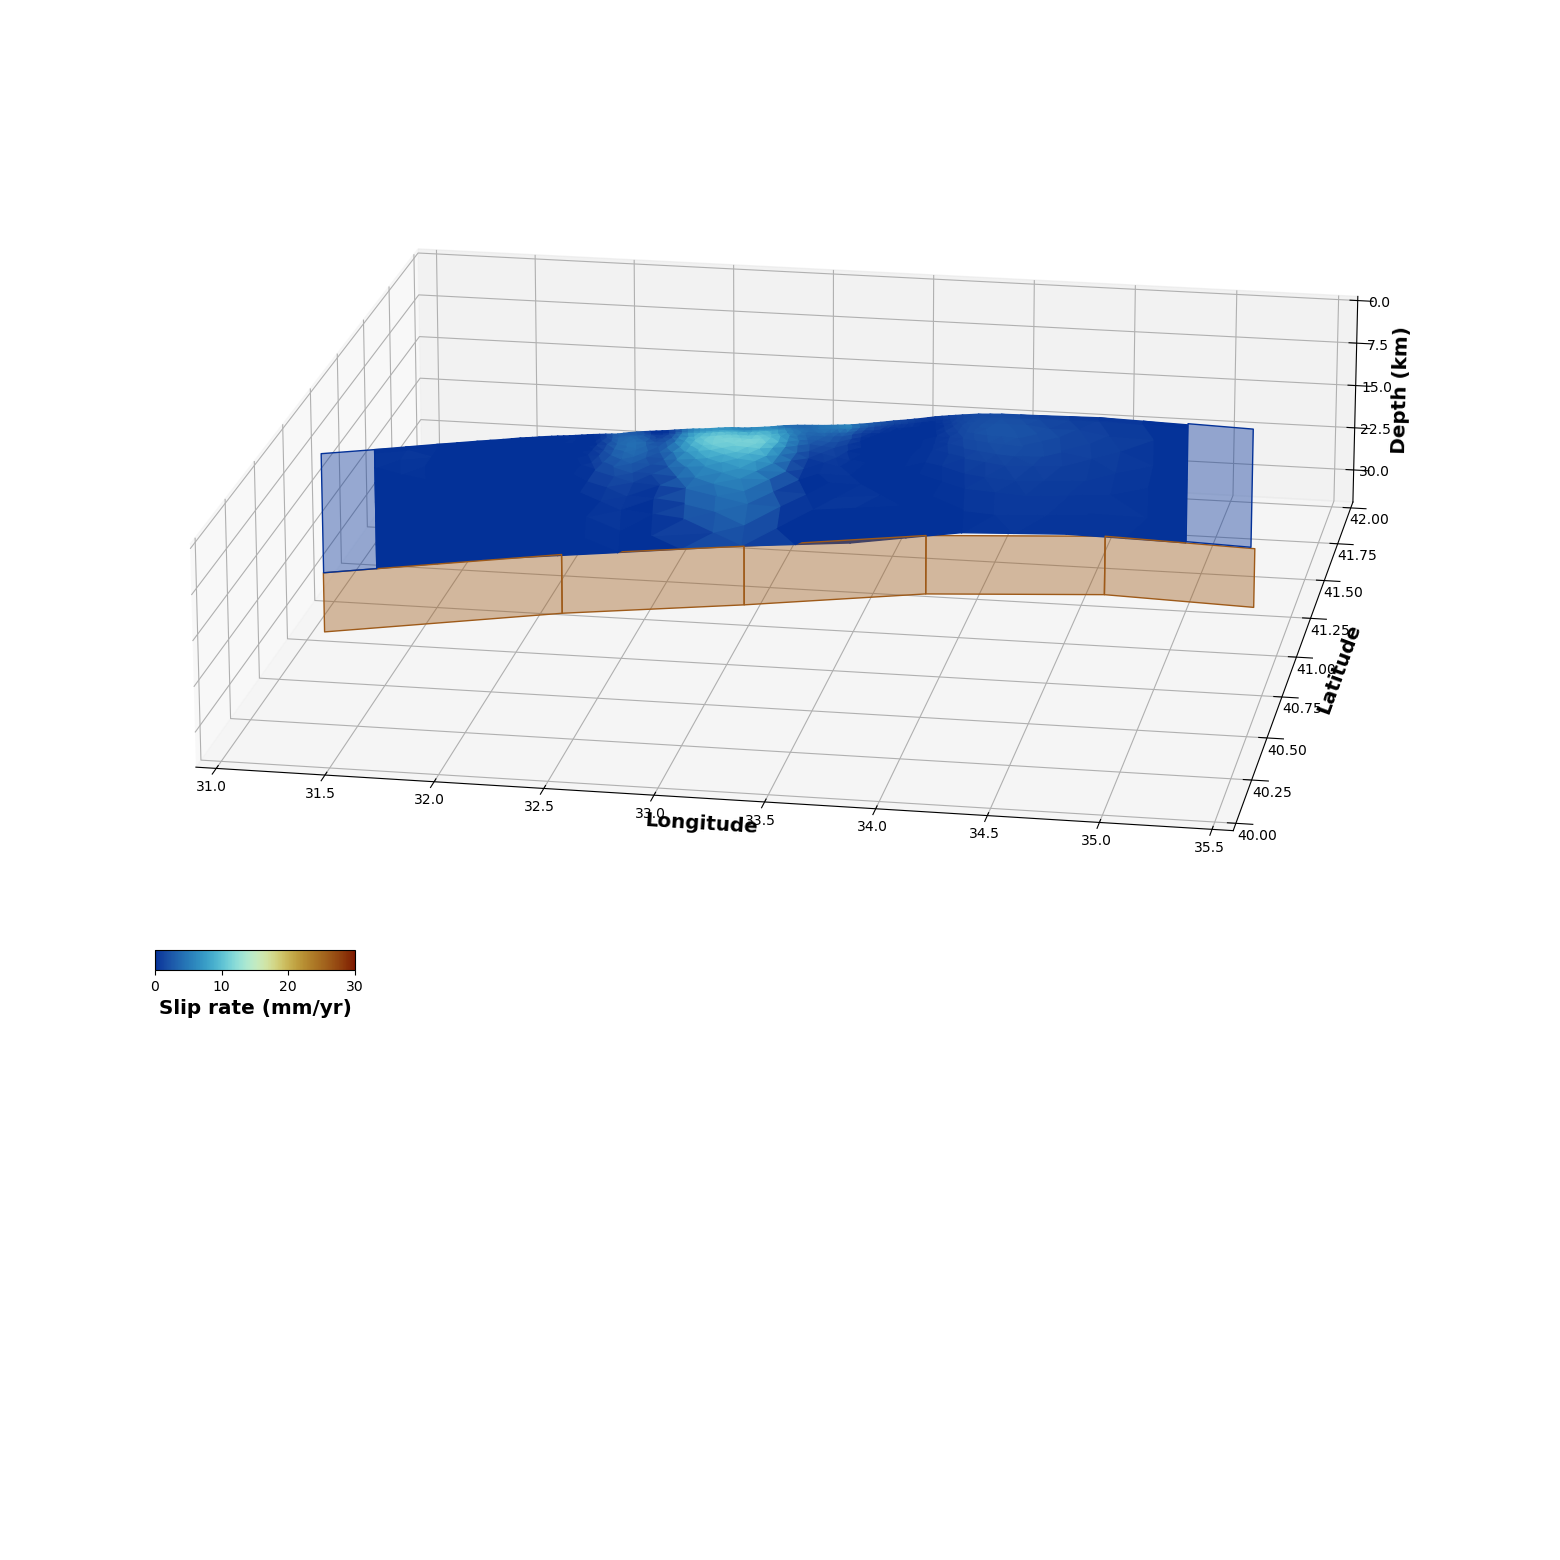

In [22]:
# Show me

# Create a figure                  
gp = geoplt(31., 40., 35.5, 42., figsize=((20,20), (15, 7)))
      
# Plot the faults
gp.faultpatches(naf, slip='strikeslip', colorbar=True, plot_on_2d=False, norm=[0, 30], cmap=cm.roma_r, 
                cbaxis=[0.2, 0.4, 0.1, 0.01], cblabel='Slip rate (mm/yr)')
gp.faultpatches(deep, slip='strikeslip', colorbar=False, alpha=0.4, plot_on_2d=False, norm=[0, 30], cmap=cm.roma_r)
gp.faultpatches(east, slip='strikeslip', colorbar=False, alpha=0.4, plot_on_2d=False, norm=[0, 30], cmap=cm.roma_r)
gp.faultpatches(west, slip='strikeslip', colorbar=False, alpha=0.4, plot_on_2d=False, norm=[0, 30], cmap=cm.roma_r)

# Set views
gp.setzaxis(30.)
gp.set_view(20., 280., shape=(1., 1., 0.3))
gp.show(showFig=['fault'])

An interesting exercise is to use the equalizeParams to link the slip value of the deep elements of the naf fault object to those slipping at depth. We did this for the Jolivet et al 2023 paper. However, in this case, since we use the AlTar sampler and no form of regularization through the model covariance matrix, the case is simpler.

## Computing Predictions

Now that we are happy with a model, we can compute the predictions and compare them to the data.

In [23]:
# Compute synthetic
for data in Datas: data.buildsynth([deep, naf, west, east, basin], direction='s')

# Compute the transformations and remove them from the data
for data in Datas: data.removeTransformation(trans)

# If for some reason, you want to add the transformation to the prediction, you can compute them and then add them to the synth attribute
# for data in InSARs: 
#       data.computePoly(trans)
#       data.synth += data.poly
# for data in [ismenet]:
#      data.computeTransformation(trans)
#      data.synth += data.tranformation

## Showing the results

The fit to the GNSS data is not that great, but, to be fair, we are using a simplified problem with a lot of smoothing... So there is so much one can do. Now it is up to you to improve this.

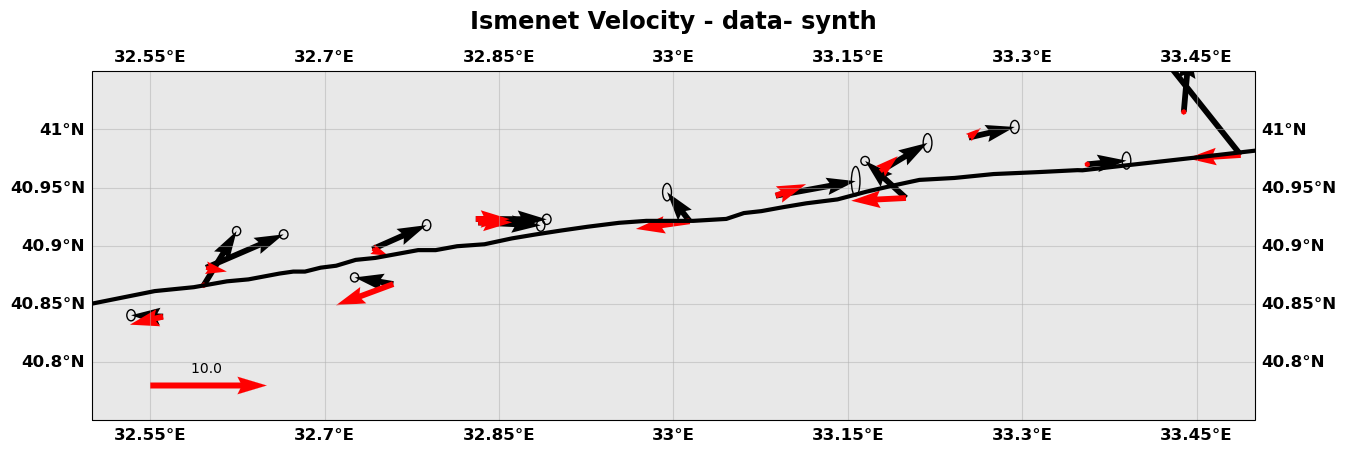

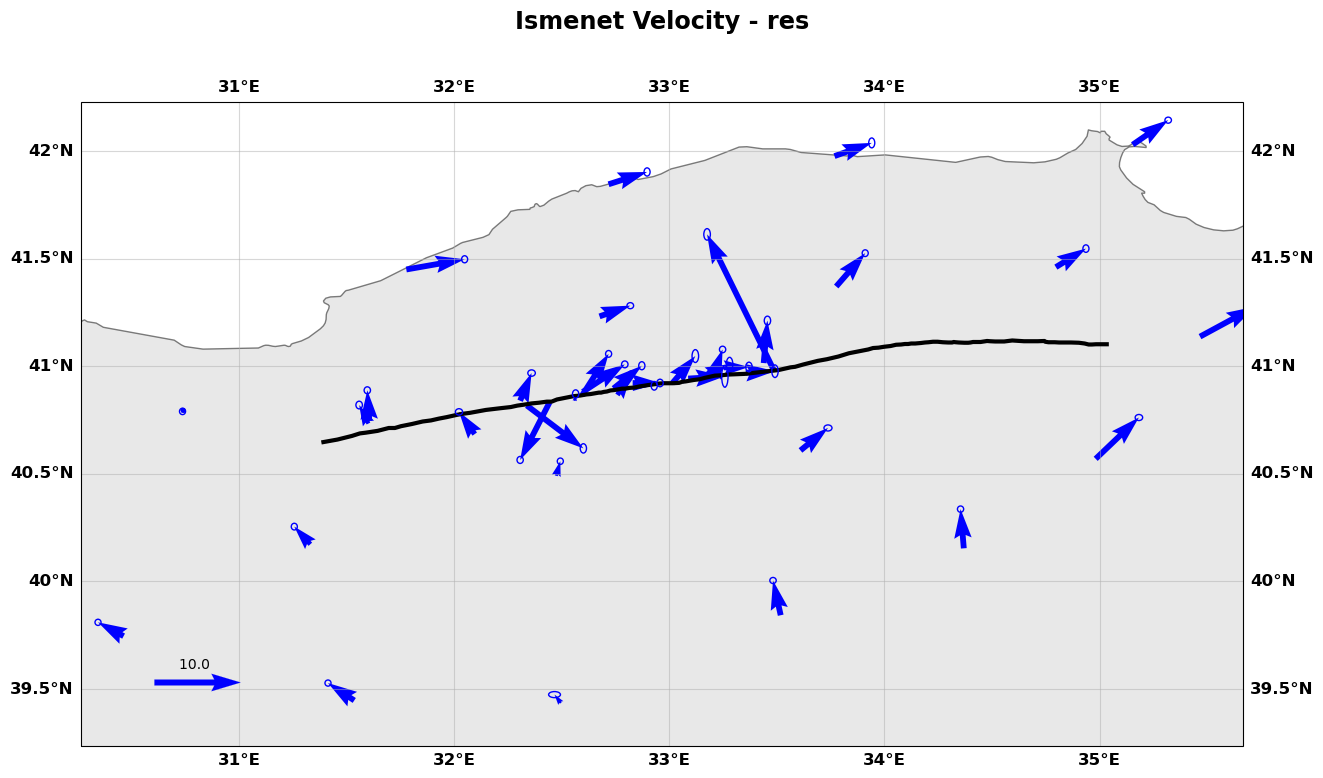

In [24]:
# We plot the GNSS data and the residuals
box = [32.5, 33.5, 40.75, 41.05]
ismenet.plot(data=['data', 'synth'], color=['k', 'r'], figsize=(15,15), scale=100., faults=[naf], box=box)
ismenet.plot(data='res', color='b', legendscale=10., scale=25., faults=[naf], figsize=(15,15))

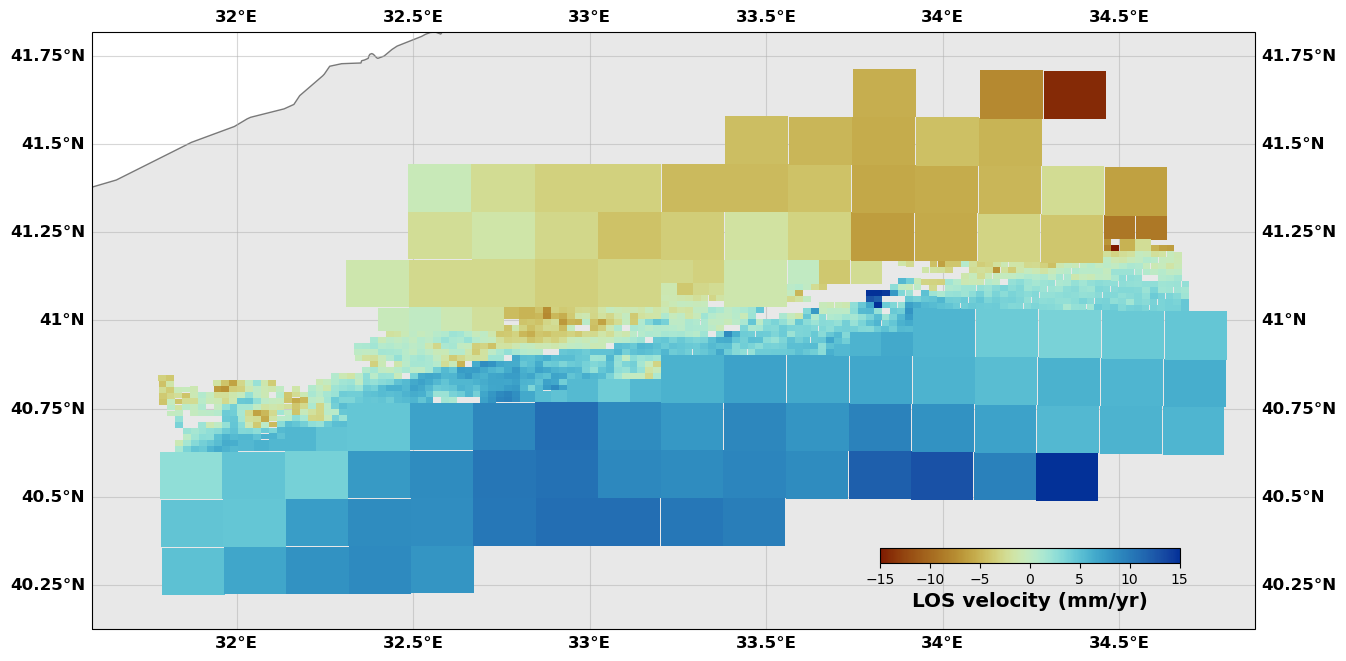

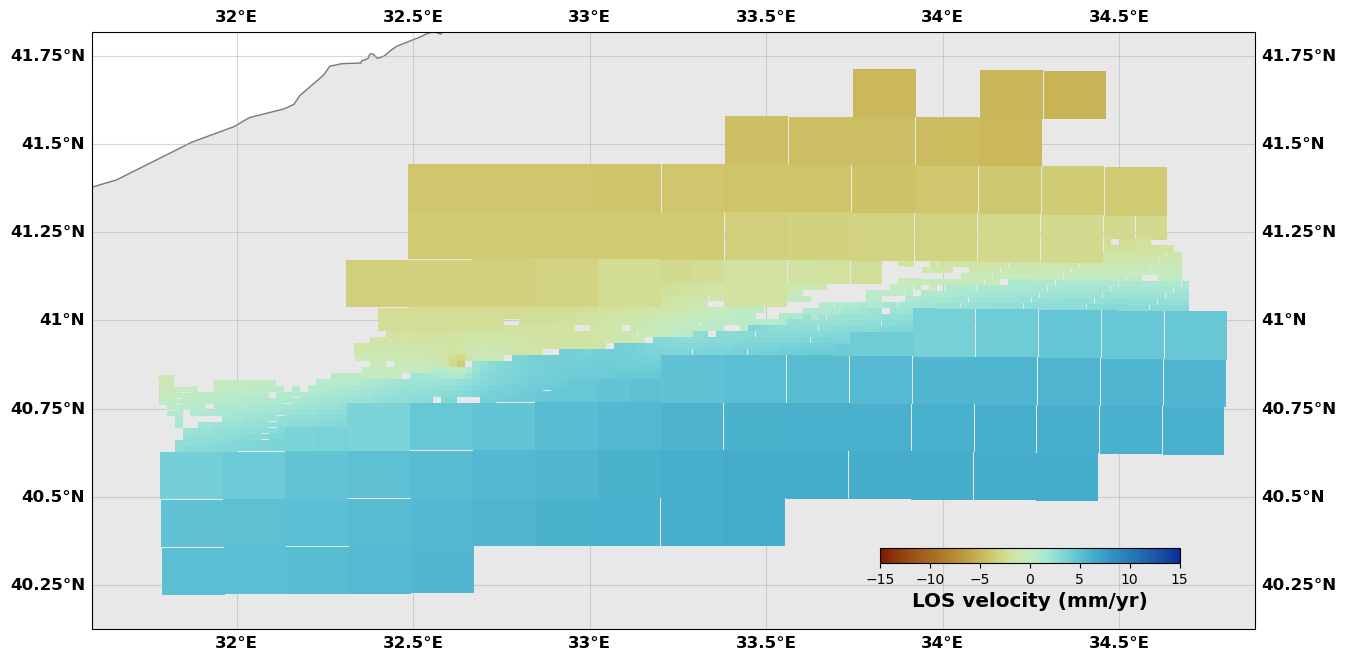

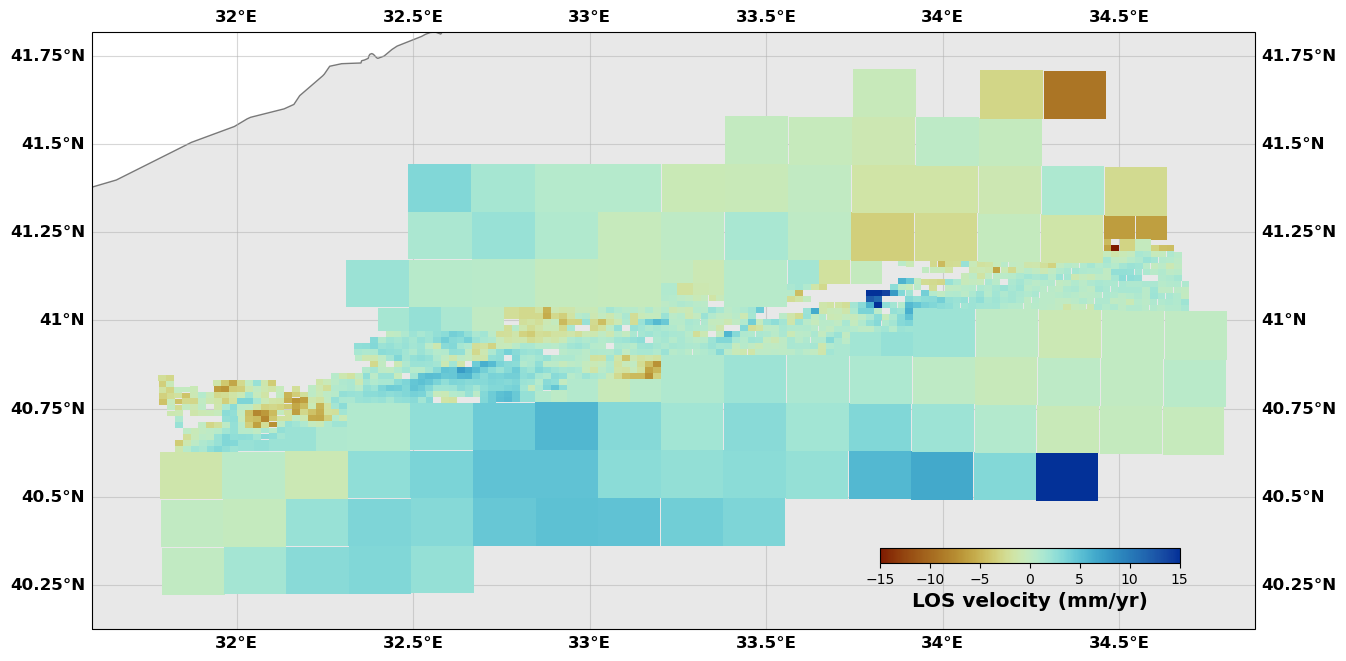

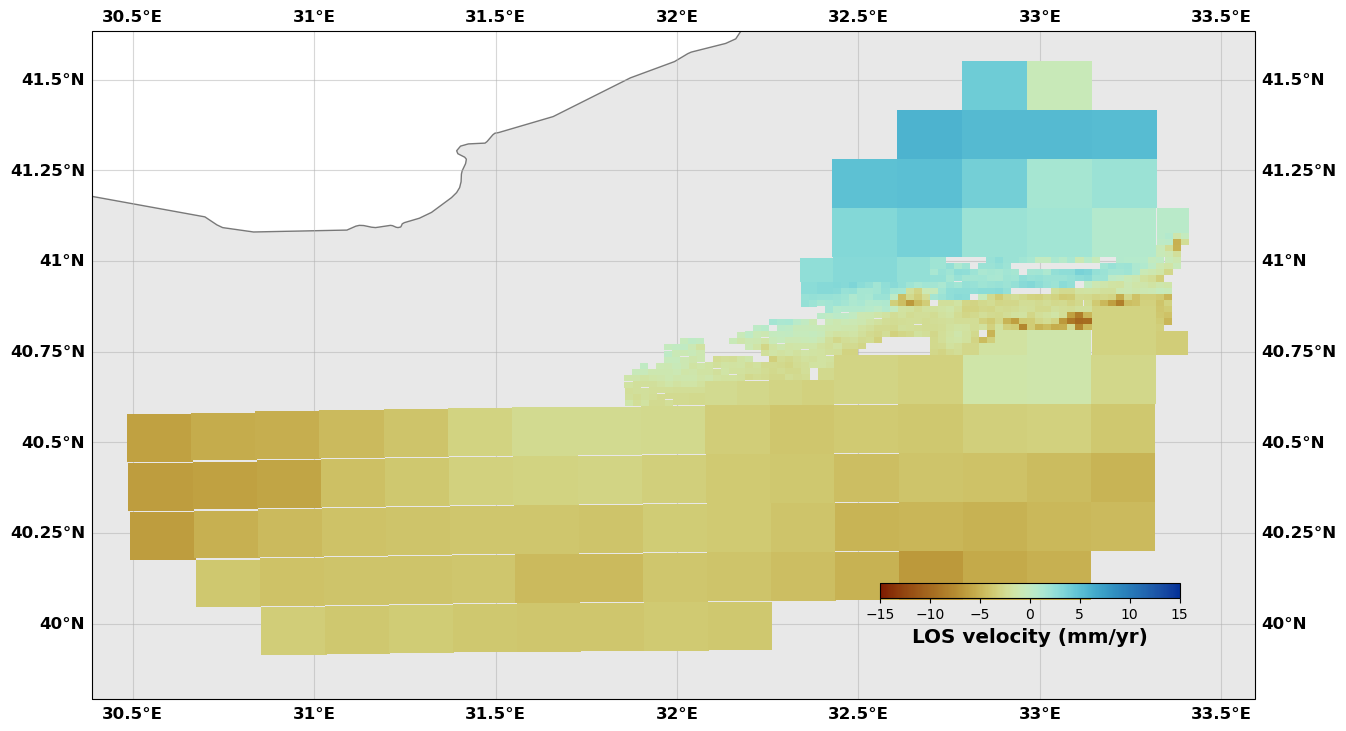

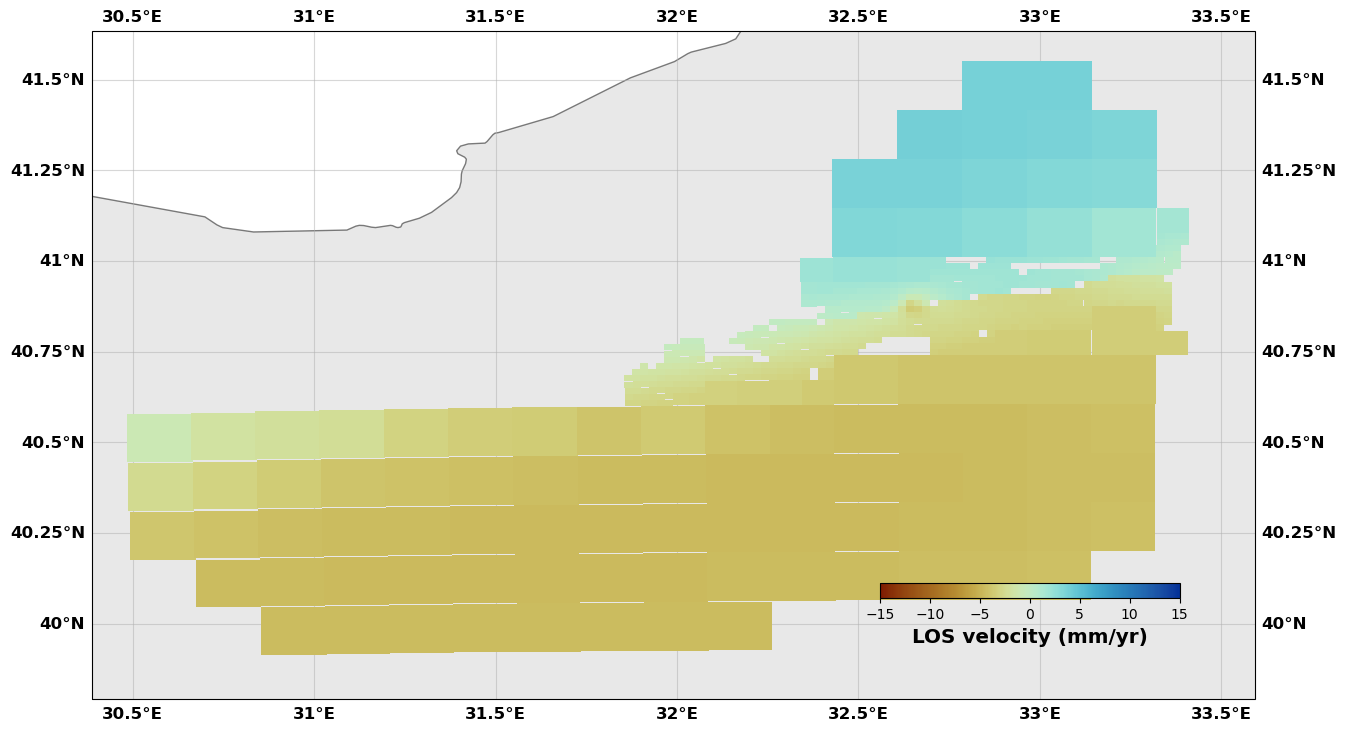

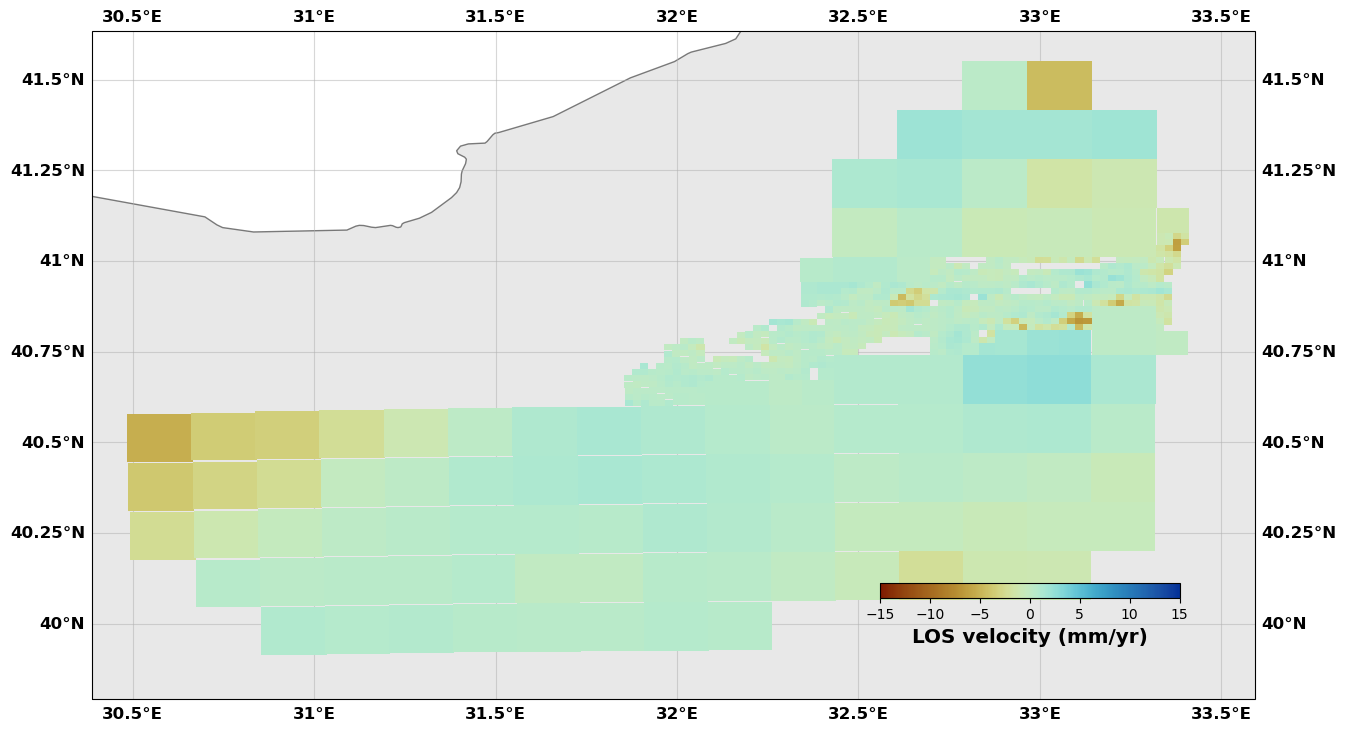

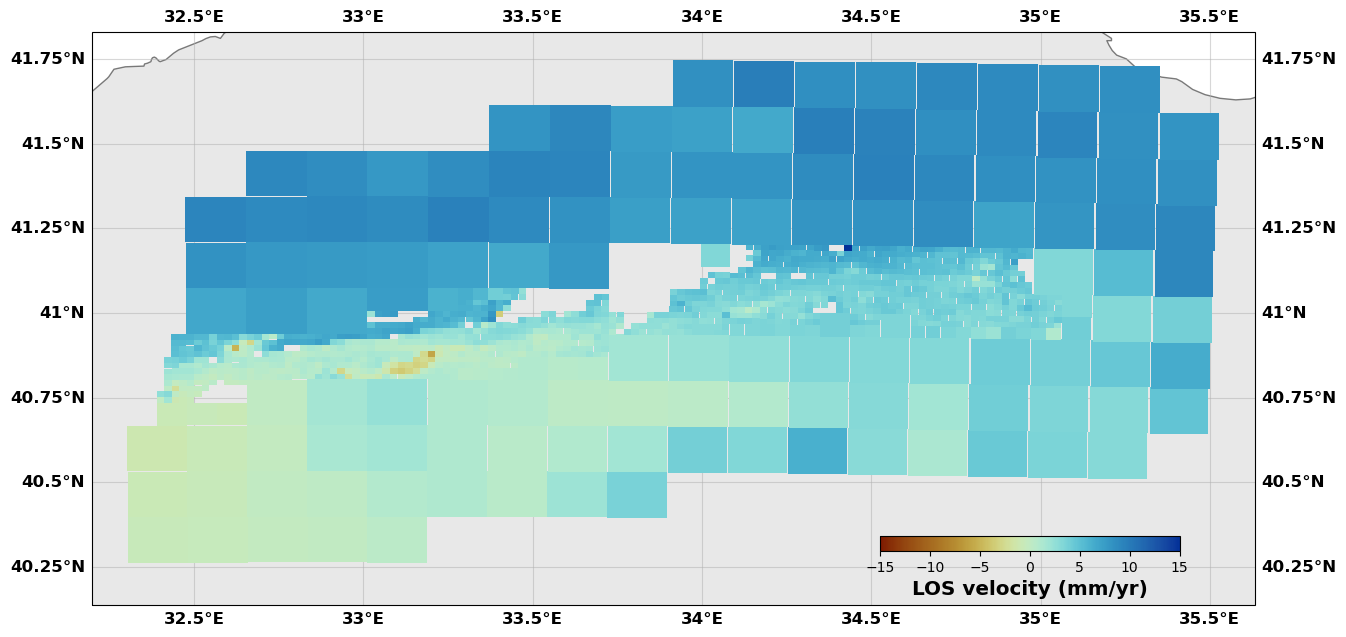

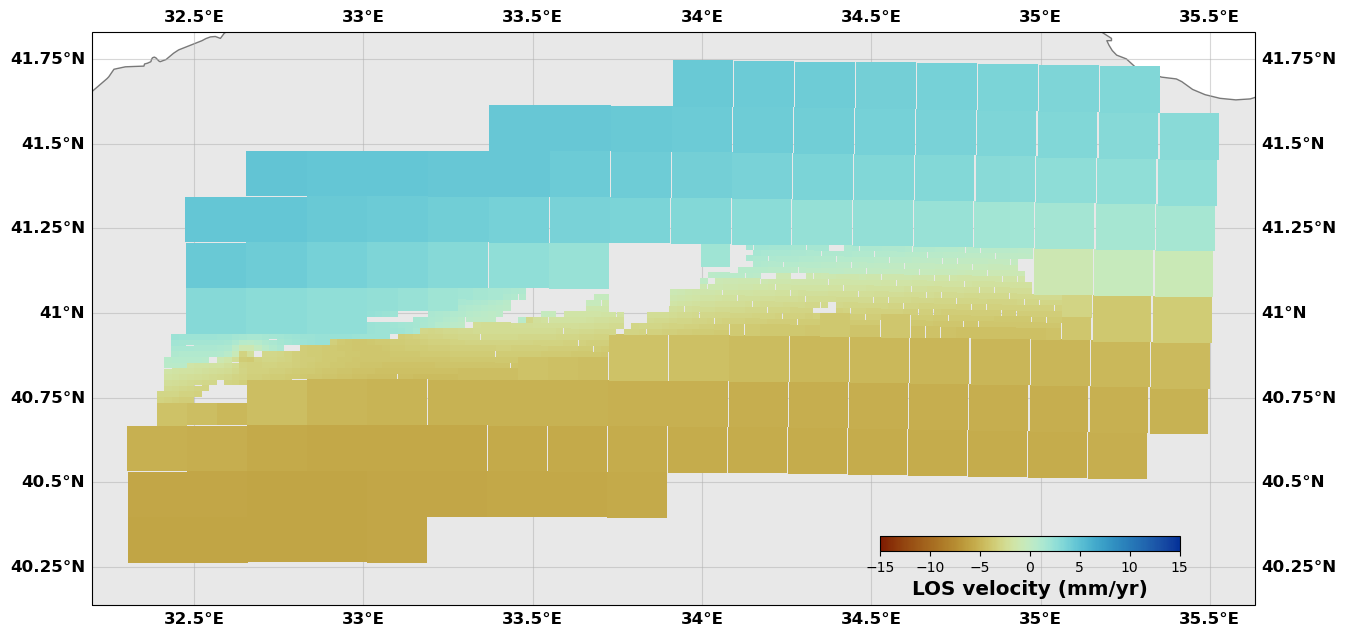

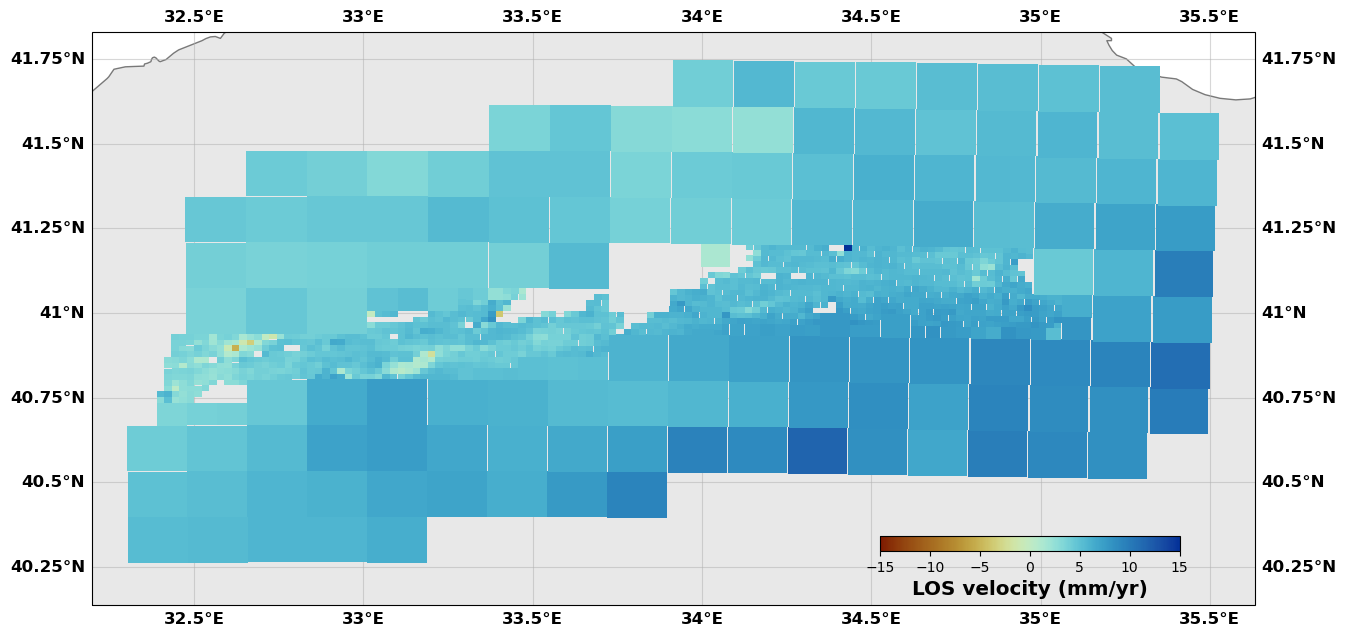

In [25]:
# We show the InSAR data and the residuals
for sar in InSARs:
    sar.plot(plotType='decimate', data='data', norm=[-15, 15], figsize=(15,15), edgewidth=0.0, 
             cmap=cm.roma, cbaxis=[0.65, 0.34, 0.2, 0.01], cblabel='LOS velocity (mm/yr)')
    sar.plot(plotType='decimate', data='synth', norm=[-15, 15], figsize=(15,15), edgewidth=0.0, 
             cmap=cm.roma, cbaxis=[0.65, 0.34, 0.2, 0.01], cblabel='LOS velocity (mm/yr)')
    sar.plot(plotType='decimate', data='res', norm=[-15, 15], figsize=(15,15), edgewidth=0.0, 
             cmap=cm.roma, cbaxis=[0.65, 0.34, 0.2, 0.01], cblabel='LOS velocity (mm/yr)')

That's it for now! 